# RNNs for Time Series Prediction

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Then of course we will need TensorFlow:

In [2]:
import os

# default - all messages
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0' 

# INFO suppressed
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# INFO and WARNING suppressed
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# INFO, WARNING, ERROR suppressed
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL']

'3'

# Time series

In [4]:
t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

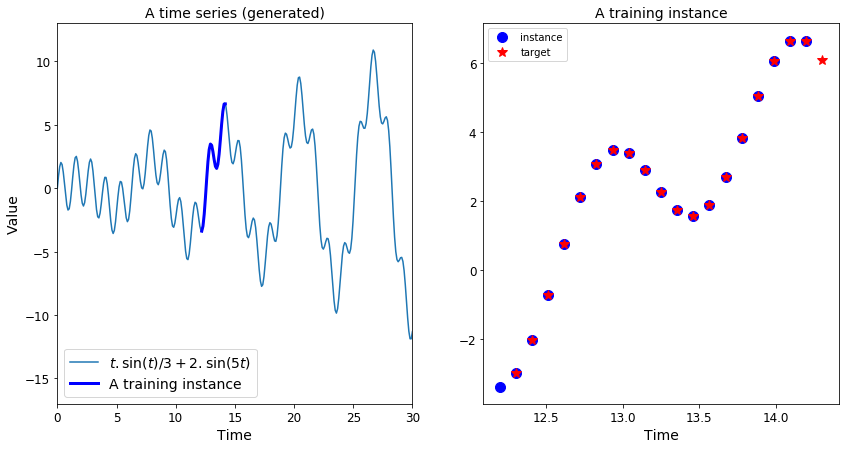

In [5]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(14,7))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "r*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")

#save_fig("time_series_plot")
plt.show()

In [6]:
X_batch, y_batch = next_batch(1, n_steps)

# Preview input/output sequences

In [7]:
np.c_[X_batch[0], y_batch[0]]

array([[ 1.03130809,  2.01304377],
       [ 2.01304377,  2.60280046],
       [ 2.60280046,  2.70745879],
       [ 2.70745879,  2.35264702],
       [ 2.35264702,  1.67590249],
       [ 1.67590249,  0.89242531],
       [ 0.89242531,  0.24181519],
       [ 0.24181519, -0.07116128],
       [-0.07116128,  0.07273599],
       [ 0.07273599,  0.67748458],
       [ 0.67748458,  1.63030808],
       [ 1.63030808,  2.72880051],
       [ 2.72880051,  3.73003212],
       [ 3.73003212,  4.40961941],
       [ 4.40961941,  4.61630268],
       [ 4.61630268,  4.30867373],
       [ 4.30867373,  3.56506597],
       [ 3.56506597,  2.56418966],
       [ 2.56418966,  1.54125682],
       [ 1.54125682,  0.7303407 ]])

## Training the model

In [9]:
reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

In [10]:
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

W0816 07:47:08.674932  7928 deprecation.py:323] From <ipython-input-10-17127253df30>:1: BasicRNNCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
W0816 07:47:08.678929  7928 deprecation.py:323] From <ipython-input-10-17127253df30>:2: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0816 07:47:08.771876  7928 deprecation.py:506] From C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to

In [11]:
n_outputs = 1
learning_rate = 0.001

In [12]:
stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

W0816 07:47:14.395659  7928 deprecation.py:323] From <ipython-input-12-b1e85bb969ed>:2: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


In [13]:
loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [14]:
n_iterations = 1000
batch_size = 50

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE:", mse)
    
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./my_time_series_model")

InternalError: Blas GEMM launch failed : a.shape=(50, 101), b.shape=(101, 100), m=50, n=100, k=101
	 [[node rnn/while/basic_rnn_cell/MatMul (defined at C:\Users\Admin\AppData\Local\Temp\tmpglk06jjw.py:14) ]]

Original stack trace for 'rnn/while/basic_rnn_cell/MatMul':
  File "C:\Anaconda3\envs\sofenn\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Anaconda3\envs\sofenn\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Anaconda3\envs\sofenn\lib\asyncio\base_events.py", line 438, in run_forever
    self._run_once()
  File "C:\Anaconda3\envs\sofenn\lib\asyncio\base_events.py", line 1451, in _run_once
    handle._run()
  File "C:\Anaconda3\envs\sofenn\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tornado\gen.py", line 781, in inner
    self.run()
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tornado\gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\ipykernel\kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\ipykernel\kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\IPython\core\interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\IPython\core\interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\IPython\core\interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\IPython\core\interactiveshell.py", line 3214, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-17127253df30>", line 2, in <module>
    rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\util\deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\ops\rnn.py", line 707, in dynamic_rnn
    dtype=dtype)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\ops\rnn.py", line 916, in _dynamic_rnn_loop
    swap_memory=swap_memory)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3501, in while_loop
    return_same_structure)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3012, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2937, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 3456, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\ops\rnn.py", line 884, in _time_step
    (output, new_state) = call_cell()
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\ops\rnn.py", line 870, in <lambda>
    call_cell = lambda: cell(input_t, state)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\ops\rnn_cell_impl.py", line 385, in __call__
    self, inputs, state, scope=scope, *args, **kwargs)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\layers\base.py", line 537, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 634, in __call__
    outputs = call_fn(inputs, *args, **kwargs)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 146, in wrapper
    ), args, kwargs)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 450, in converted_call
    result = converted_f(*effective_args, **kwargs)
  File "C:\Users\Admin\AppData\Local\Temp\tmpglk06jjw.py", line 14, in tf__call
    gate_inputs = ag__.converted_call('matmul', math_ops, ag__.ConversionOptions(recursive=True, force_conversion=False, optional_features=(), internal_convert_user_code=True), (ag__.converted_call('concat', array_ops, ag__.ConversionOptions(recursive=True, force_conversion=False, optional_features=(), internal_convert_user_code=True), ([inputs, state], 1), None), self._kernel), None)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 356, in converted_call
    return _call_unconverted(f, args, kwargs)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 255, in _call_unconverted
    return f(*args)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\util\dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\ops\math_ops.py", line 2647, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 5925, in mat_mul
    name=name)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\framework\ops.py", line 3616, in create_op
    op_def=op_def)
  File "C:\Anaconda3\envs\sofenn\lib\site-packages\tensorflow\python\framework\ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
y_pred

In [ ]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

## Generating a creative new sequence

In [ ]:
with tf.Session() as sess:                        
    saver.restore(sess, "./my_time_series_model")

    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, "./my_time_series_model")

    # sequence of zeros
    sequence1 = [0. for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence1[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0, -1, 0])

    # sequence of original time series
    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
#save_fig("creative_sequence_plot")
plt.show()